Softmax Regression:


In [41]:
import pandas as pd
import numpy as np

# Load Titanic dataset
data = pd.read_csv('Titanic-Dataset.csv')

# Prepare features (X) and target labels (y)
X = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
y = data['Survived']

# Handle missing values
X['Age'].fillna(X['Age'].median(), inplace=True)
X['Fare'].fillna(X['Fare'].median(), inplace=True)

# Encode 'Sex' column
X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})

# Convert to numpy arrays
X = X.values
y = y.values


<ipython-input-41-f4b6cd15a3b5>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['Age'].fillna(X['Age'].median(), inplace=True)
<ipython-input-41-f4b6cd15a3b5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Age'].fillna(X['Age'].median(), inplace=True)
<ipython-input-41-f4b6cd15a3b5>:13: FutureWarning: A value is trying to be set on a

In [42]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)



Softmax function:

In [43]:
def softmax(z):
    max_z = np.max(z, axis=1).reshape(-1, 1)  # Reshape (n_samples,) to (n_samples, 1)
    exp_z = np.exp(z - max_z)  # Subtract max for numerical stability
    sum_exp_z = np.sum(exp_z, axis=1).reshape(-1, 1)  # Reshape for element-wise division
    return exp_z / sum_exp_z  # Normalize


Cross entropy loss Function:


In [44]:
import numpy as np

def cross_entropy_loss(y_true, y_pred):
    # Small value added to avoid log(0), which is undefined
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip predictions to prevent log(0)

    # Calculate the cross-entropy loss
    loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))  # Summing over class labels and averaging
    return loss


Gradient descent

In [45]:
def gradient_descent(X, y_onehot, w, b, learning_rate, n_iterations, tolerance=1e-5):
    m = X.shape[0]
    prev_loss = float('inf')
    for i in range(n_iterations):
        # Compute predictions
        z = np.dot(X, w) + b
        y_pred = softmax(z)

        # Compute gradients
        grad_w = np.dot(X.T, (y_pred - y_onehot)) / m
        grad_b = np.sum(y_pred - y_onehot, axis=0) / m

        # Update weights and bias
        w -= learning_rate * grad_w
        b -= learning_rate * grad_b

        # Compute loss
        loss = cross_entropy_loss(y_onehot, y_pred)
        if abs(prev_loss - loss) < tolerance:
            print(f"Converged at iteration {i}: Loss = {loss:.4f}")
            break
        prev_loss = loss

        if i % 100 == 0 or i == n_iterations - 1:
            print(f"Iteration {i}: Loss = {loss:.4f}")

    return w, b


Confusion matrix

In [46]:
def confusion_matrix(y_true, y_pred, n_classes):
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        cm[true, pred] += 1
    return cm


Precision

In [47]:
import numpy as np

def precision(conf_matrix):
    # Extract true positives (diagonal elements)
    TP = np.diag(conf_matrix)
    # Extract false positives (sum of each column minus the diagonal)
    FP = np.sum(conf_matrix, axis=0) - TP

    # Avoid division by zero
    precision_values = TP / (TP + FP)

    return precision_values


Recall

In [48]:
import numpy as np

def recall(conf_matrix):
    # Extract true positives (diagonal elements)
    TP = np.diag(conf_matrix)
    # Extract false negatives (sum of each row minus the diagonal)
    FN = np.sum(conf_matrix, axis=1) - TP

    # Avoid division by zero
    recall_values = TP / (TP + FN)

    return recall_values


F1- Score

In [49]:
import numpy as np

def f1_score(precision_values, recall_values):
    # Calculate the F1 score for each class
    f1_values = 2 * (precision_values * recall_values) / (precision_values + recall_values)

    # Replace NaN values with 0 (for cases where precision + recall = 0)
    f1_values = np.nan_to_num(f1_values)

    return f1_values


Training

In [50]:
# One-hot encode y_train
n_classes = len(np.unique(y_train))
y_onehot = np.zeros((y_train.shape[0], n_classes))
y_onehot[np.arange(y_train.shape[0]), y_train] = 1

# Initialize weights and bias
n_features = X_train.shape[1]
w = np.random.randn(n_features, n_classes)
b = np.zeros(n_classes)

# Train model
learning_rate = 0.1
n_iterations = 1000
w, b = gradient_descent(X_train, y_onehot, w, b, learning_rate, n_iterations)


Iteration 0: Loss = 1.0930
Iteration 100: Loss = 0.4625
Iteration 200: Loss = 0.4520
Converged at iteration 268: Loss = 0.4507


Predict and accuracy:

In [54]:
def predict(X, w, b):
    z = np.dot(X, w) + b
    y_prob = softmax(z)
    return np.argmax(y_prob, axis=1)

# Make predictions
y_pred = predict(X_test, w, b)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, n_classes)
print("Confusion Matrix:")
print(cm)

# Compute metrics for each class
precision_score = precision(cm)
recall_score = recall(cm)
f1_score_value = f1_score(precision_score, recall_score)

# Print the results
print(f"Precision: {precision_score}")
print(f"Recall: {recall_score}")
print(f"F1-Score: {f1_score_value}")



Accuracy: 0.8045
Confusion Matrix:
[[93 12]
 [23 51]]
Precision: [0.80172414 0.80952381]
Recall: [0.88571429 0.68918919]
F1-Score: [0.84162896 0.74452555]


Visualization of confusion matrix

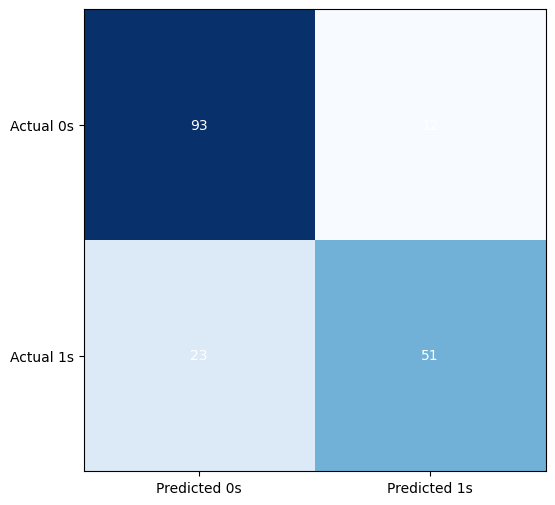

In [55]:
# Visualizing Confusion Matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, n_classes)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Display the confusion matrix as an image
ax.imshow(cm, cmap='Blues')

# Remove grid lines
ax.grid(False)

# Set x-axis tick labels
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))

# Set y-axis tick labels
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))

# Set y-axis limits
ax.set_ylim(1.5, -0.5)

# Display the values in the confusion matrix
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')

# Show the plot
plt.show()